In [ ]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('Chinook.db')
cursor = conn.execute("select * from Artist LIMIT 10")
rows = cursor.fetchall()

rows

In [ ]:
data = ''
with open('Chinook_db_description.txt','r') as file:
    data= file.readlines()

text = " ".join(data)
print(text)


In [ ]:
import openai
from openai import OpenAI
from dotenv import load_dotenv, dotenv_values 
from PIL import Image
from io import BytesIO
import time
import pandas as pd
import datetime

load_dotenv()
client = OpenAI()


In [ ]:
user_query = "Create a plot of the total spend of the top 10 users. Use vertical labels for the x axis"
#user_query = "What is the total spend per user"

In [ ]:
schema_template = "Here is the schema of a database. "+text\
    +"\n Write a SQL query to answer the following question. Provide only the SQL and nothing else\n"
user_request = schema_template+user_query
print(user_request)

In [ ]:
def llm_request(user_prompt):
    completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": "You helpful data analyst.Use only the information provided in the text."},
        {"role": "user", "content": user_prompt}
    ]
    )

    result = completion.choices[0].message.content
    return result


In [ ]:
result = llm_request(user_request)
my_SQL = result[7:-3]
print(my_SQL)

df = pd.read_sql(my_SQL,conn)
df.head()

In [ ]:
request = "Here is a sample dataframe\n "+ df.head(10).to_string() \
    + "\n Provide only Python code to answer the question and nothing else. "\
    + "Assume that the data is available in a dataframe df, and use only data from the sample provided. "\
    + "Don't include any data in the code. "\
    + "Any plots should have a size of 10,5 and a dpi of 300. \
      Use seaborn to generate the plots, if possible. Save the image as a png in the \
        current directory with the name plot_image.png\
        Question: "
request += user_query
print(request)

import os
os.getcwd()

In [ ]:
current_path = os.getcwd()
filepath = os.path.join(current_path,"plot_image.png")
filepath

In [ ]:
result = llm_request(request)
#print(result)
code = result[10:-3]
print(code)

In [ ]:
max_tries = 5
tries = 0
while tries < max_tries:
    try:
        exec(code)
        break
    except Exception as e:
        tries +=1
        print(e)

In [ ]:
df.columns

In [ ]:
code = """
import matplotlib.pyplot as plt
import seaborn as sns

# top_10_users = df.nlargest(10, 'TotalSpend')
# plt.figure(figsize=(10, 5), dpi=300)
# sns.barplot(y='CustomerId', x='TotalSpend', data=top_10_users)
# plt.xlabel('Total Spend')
# plt.ylabel('Customer ID')
#plt.savefig('plot_image.png')
#output = plt.savefig('plot_image.png')
output = df
# """

In [ ]:
type(exec(code,{'df':df}))



In [3]:
import pandas as pd

df = pd.read_csv("data.csv")
df.head()


,Artist_Name,Total_Sales
0,Iron Maiden,138.60
1,U2,105.93
2,Metallica,90.09
3,Led Zeppelin,86.13
4,Lost,81.59


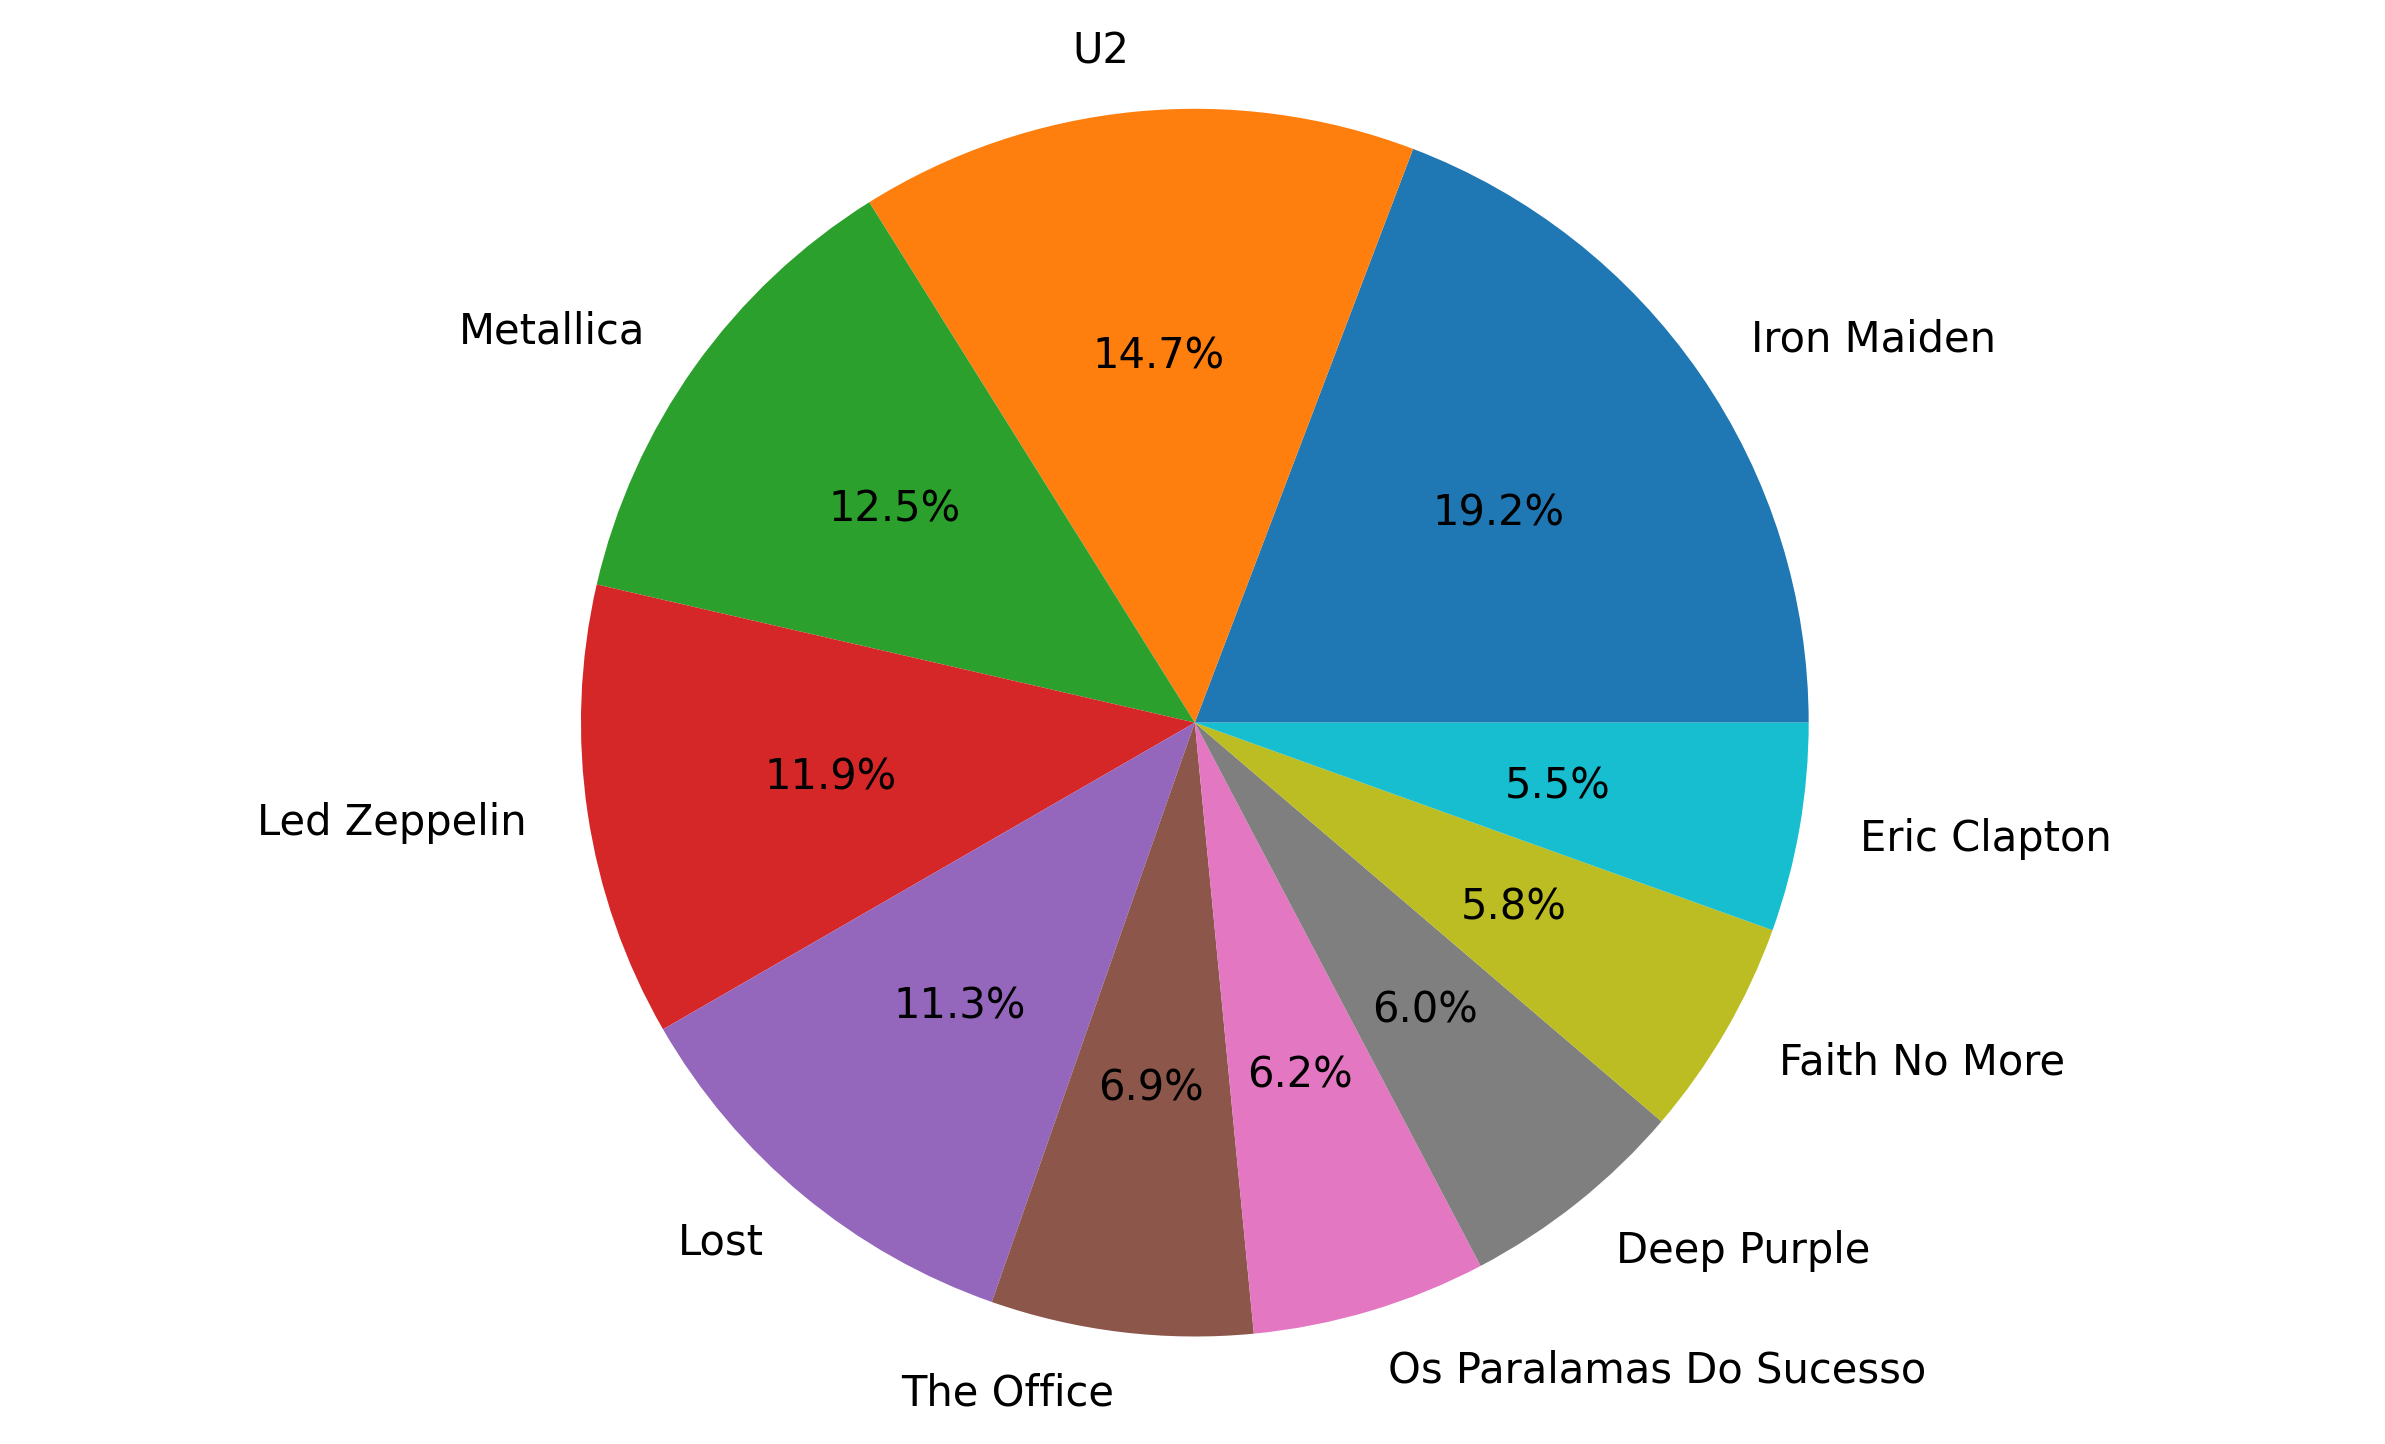

In [6]:


import matplotlib.pyplot as plt 
import pandas as pd

plt.figure(figsize=(10, 6), dpi=300) 
plt.pie(df['Total_Sales'], labels=df['Artist_Name'],  autopct='%1.1f%%') 
plt.axis('equal') 
plt.savefig('plot_image.png')